# TM10007 Assignment Final Code

## Imports

In [1]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

In [2]:
# import packages
# general
import numpy as np
import pandas as pd 
from pandas.core.internals.construction import dataclasses_to_dicts
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn as sns
from sklearn.model_selection import train_test_split
# Scalers
from sklearn.preprocessing import RobustScaler, StandardScaler
# Feature selection
from sklearn.feature_selection import SelectKBest, f_classif
from scipy import stats
# PCA
from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
# Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
# lasso 
from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import roc_curve, auc
# Metrics and Validation
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score, plot_roc_curve
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score


## Loading the data

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [3]:
from hn.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of features: {len(data.columns)}')
type(data)


The number of samples: 113
The number of features: 160


pandas.core.frame.DataFrame

## Split Data - Train and test set

In [4]:
# Reassign label to 0 and 1
data_bin = data.replace(to_replace=['T12', 'T34'], value=[0, 1])
# Make an object with the label for each sample
y_label = data_bin['label']
# Make an object with all other data
x_data = data_bin.drop(columns='label')
# Split the data with regards to samples, not features
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_data, y_label, test_size=0.2, train_size=0.8, random_state=42, stratify=y_label)

# Pre-processing and orientation

## Missing Data

In [5]:
# Concatenate x_train and y_train
train = pd.concat([x_train, y_train], axis=1)

# Print features with >45% zeroes
# Label is also printed, since the values were made binary, 
# but label will obviously not be tested
for column_name in train.columns:
  column = train[column_name]
  count = (column == 0).sum()
  perc = (count/len(train))*100
  if perc >= 45:
      print(column_name)

tf_GLRLM_GrayLevelVariance
tf_GLSZM_GrayLevelVariance
tf_NGTDM_Busyness
tf_NGTDM_Complexity
tf_NGTDM_Contrast
tf_NGTDM_Strength
label


In [6]:
# Testing the features with >45% zeroes: significant information or not?

# extract columns by label
df_T12 = train.loc[train['label'] == 0]
df_T34 = train.loc[train['label'] == 1]

# T-test for feature tf_GLRLM_GrayLevelVariance
glrlm_glv_T12 = df_T12.pop('tf_GLRLM_GrayLevelVariance')
glrlm_glv_T34 = df_T34.pop('tf_GLRLM_GrayLevelVariance')
print(f'p-value tf_GLRLM_GrayLevelVariance = {stats.ttest_ind(glrlm_glv_T12, glrlm_glv_T34, axis = 0).pvalue}')

# T-test for feature tf_GLSZM_GrayLevelVariance
glszm_glv_T12 = df_T12.pop('tf_GLSZM_GrayLevelVariance')
glszm_glv_T34 = df_T34.pop('tf_GLSZM_GrayLevelVariance')
print(f'p-value tf_GLSZM_GrayLevelVariance = {stats.ttest_ind(glszm_glv_T12, glszm_glv_T34, axis = 0).pvalue}')

# T-test for feature tf_NGTDM_Busyness
busyness_T12 = df_T12.pop('tf_NGTDM_Busyness')
busyness_T34 = df_T34.pop('tf_NGTDM_Busyness')
print(f'p-value tf_NGTDM_Busyness = {stats.ttest_ind(busyness_T12, busyness_T34, axis = 0).pvalue}')

# T-test for feature tf_NGTDM_Complexity
complex_T12 = df_T12.pop('tf_NGTDM_Complexity')
complex_T34 = df_T34.pop('tf_NGTDM_Complexity')
print(f'p-value tf_NGTDM_Complexity = {stats.ttest_ind(complex_T12, complex_T34, axis = 0).pvalue}')

# T-test for feature tf_NGTDM_Contrast
contrast_T12 = df_T12.pop('tf_NGTDM_Contrast')
contrast_T34 = df_T34.pop('tf_NGTDM_Contrast')
print(f'p-value tf_NGTDM_Contrast = {stats.ttest_ind(contrast_T12, contrast_T34, axis = 0).pvalue}')

# T-test for feature tf_NGTDM_Strength
strength_T12 = df_T12.pop('tf_NGTDM_Strength')
strength_T34 = df_T34.pop('tf_NGTDM_Strength')
print(f'p-value tf_NGTDM_Strength = {stats.ttest_ind(strength_T12, strength_T34, axis = 0).pvalue}')



p-value tf_GLRLM_GrayLevelVariance = 0.2894199133193955
p-value tf_GLSZM_GrayLevelVariance = 0.04859571985261727
p-value tf_NGTDM_Busyness = 0.02580191533015353
p-value tf_NGTDM_Complexity = 0.9198598273645741
p-value tf_NGTDM_Contrast = 0.7802936556901033
p-value tf_NGTDM_Strength = 0.7619197127205034


## Visualisation with PCA

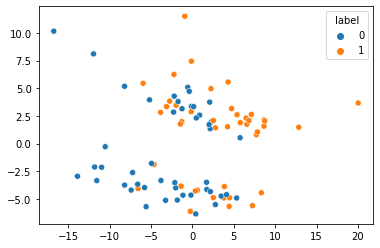

In [7]:
# Get an indication of the complexity of the problem: linearly separable or not?

# PCA analysis
pca_vis = PCA(n_components=2)
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca_vis)])
pipe.fit(x_train)
x_pca_vis = pipe.transform(x_train)

# Visualise
sns.scatterplot(x=x_pca_vis[:, 0], y=x_pca_vis[:, 1], hue=y_train)

## Outliers

The presence of outliers determines the method of feature scaling that is used later on.

In [8]:
# Determine the Z-Score
# This part gives a Runtime warning, but the z-scores are only used to determine
# whether there are outliers, so we ignore this warning for now.

for column in x_train:
    z_score = np.abs(stats.zscore(x_train[column]))

z_thresh = 3
print(np.where(z_score > z_thresh))

(array([ 2,  6, 11, 20, 71]),)


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


## Feature scaling

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


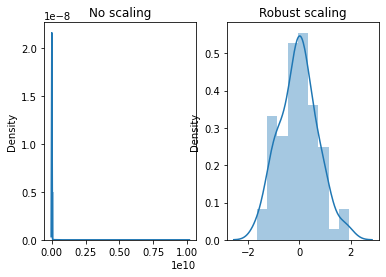

In [9]:
# Outliers detected through Z-test, so use of Robust Scaler is indicated
robust_scaler = RobustScaler()
robust_scaler.fit(x_train)
x_scaled = robust_scaler.transform(x_train)

fig, ax =plt.subplots(1,2)
sns.distplot(x_train, ax=ax[0]).set(title='No scaling')
sns.distplot(x_scaled[:,1], ax=ax[1]).set(title='Robust scaling')
fig.show()

# Feature selection

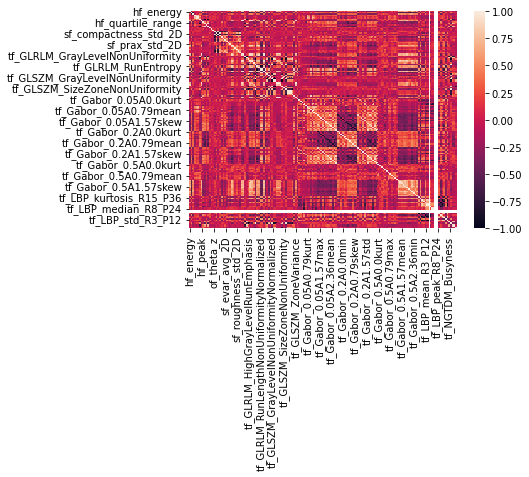

In [10]:
# Heatmap of the correlations between all features
corr = x_train.corr()
sns.heatmap(corr)

In [11]:
# Univariate t-testing

df_T12 = x_train.loc[data['label'] == "T12"]
df_T34 = x_train.loc[data['label'] == "T34"]

_, p_values = stats.ttest_ind(df_T12, df_T34)
features_sig = []
for subj, value in enumerate(p_values):
  if value < 0.05:
    features_sig.append(list(x_train.columns)[subj])

print(f'{len(features_sig)} of {len(x_train.columns)} features were selected')

x_train_t = x_train[features_sig]

77 of 159 features were selected


In [12]:
# Univariate ANOVA F-testing
# This step produces a Runtime warning, since it calculated a/some 
# within variance(s) as zero, which would mean a divide by zero. Since it does
# not produce an error, we ignore this warning for now.
# Configure to select the features with the top half f-scores
k_median = len(x_train.columns)//2
x_scaled_df = pd.DataFrame(x_scaled)
f_test = SelectKBest(score_func=f_classif, k=k_median)
f_test.fit(x_scaled_df, y_train)

# Apply ANOVA F-test to the train set
x_ftest = f_test.transform(x_scaled_df)

rows, columns = x_ftest.shape
print(f'{columns} of {len(x_train.columns)} features were selected')

79 of 159 features were selected


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [142 145 146 147] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [13]:
# LASSO as feature selection

# Select all features with a weight above the median.
selector = SelectFromModel(estimator=Lasso(alpha=10**(-10), random_state=42), threshold='median')
# Fit and apply the selector to the train set
selector.fit(x_scaled, y_train)
n_original = x_scaled.shape[1]
x_scaled_lasso = selector.transform(x_scaled)

n_selected = x_scaled_lasso.shape[1]

print(f"Selected {n_selected} from {n_original} features.")

Selected 80 from 159 features.


# Feature extraction


In [14]:
# Fit a PCA on the scaled training data
pca = PCA().fit(x_scaled)

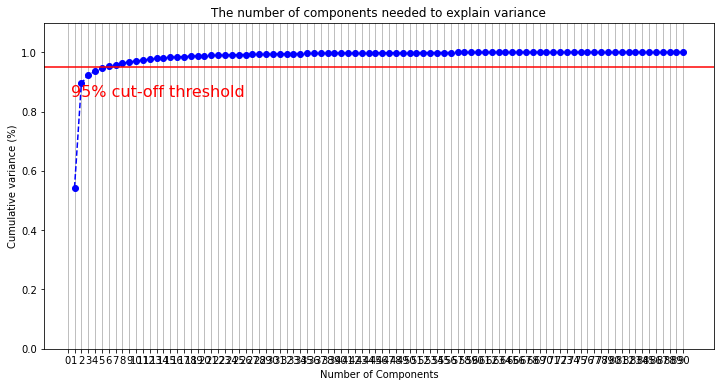

The optimal number of components is 6, as shown in the plot.


In [15]:
# Determine the optimal number of principal components:
# Where the cumulative variance crosses the 95% threshold
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 91, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 91, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

print('The optimal number of components is 6, as shown in the plot.')

In [16]:
# PCA analysis
pca_extr = PCA(n_components=6)
pca_extr.fit(x_scaled)
x_pca_extr = pca_extr.transform(x_scaled)

## Complexity

In [17]:
# Construct classifiers
n_estimators = (1, 5, 200)
clsfs = [RandomForestClassifier(n_estimators=n_estimators[0], random_state=42),
         RandomForestClassifier(n_estimators=n_estimators[1], random_state=42),
         RandomForestClassifier(n_estimators=n_estimators[2], random_state=42)]

# Create datasets to loop over
Xs = x_scaled
Ys = y_train

# Classifiers applied to the dataset:
num = 0

for clf in clsfs:
  # Split data in training and testing
  X_des, X_val, y_des, y_val = train_test_split(Xs, Ys, test_size=0.25, train_size=0.75, random_state=42)
  
  clf.fit(X_des, y_des)
  y_pred = clf.predict(X_val)
  t = ("For %d trees, misclassified: %d / %d" % (n_estimators[num], (y_val != y_pred).sum(), y_val.shape[0]))
  print(t)
  num += 1

For 1 trees, misclassified: 7 / 23
For 5 trees, misclassified: 5 / 23
For 200 trees, misclassified: 6 / 23


# Classifiers and tuning

##Lasso

###Model 1 - Lasso + SCV polynomial

In [18]:
# Hyperparameters 
# defining parameter range
param_grid_lasso_poly = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'degree': [1, 2, 3, 4, 5],
              'coef0':[0.01, 0.5, 1],
              'kernel': ['poly']}
 
grid_lasso_poly =  RandomizedSearchCV(SVC(), param_grid_lasso_poly, refit = True, verbose = 3, random_state=42)
 
# fitting the model for randomized search
grid_lasso_poly.fit(x_scaled_lasso, y_train)

# print how our model looks after hyper-parameter tuning
print(grid_lasso_poly.best_estimator_)



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END C=10, coef0=0.01, degree=4, gamma=0.01, kernel=poly;, score=0.722 total time=   0.0s
[CV 2/5] END C=10, coef0=0.01, degree=4, gamma=0.01, kernel=poly;, score=0.556 total time=   0.0s
[CV 3/5] END C=10, coef0=0.01, degree=4, gamma=0.01, kernel=poly;, score=0.500 total time=   0.0s
[CV 4/5] END C=10, coef0=0.01, degree=4, gamma=0.01, kernel=poly;, score=0.500 total time=   0.0s
[CV 5/5] END C=10, coef0=0.01, degree=4, gamma=0.01, kernel=poly;, score=0.556 total time=   0.0s
[CV 1/5] END C=0.1, coef0=0.5, degree=2, gamma=0.001, kernel=poly;, score=0.500 total time=   0.0s
[CV 2/5] END C=0.1, coef0=0.5, degree=2, gamma=0.001, kernel=poly;, score=0.500 total time=   0.0s
[CV 3/5] END C=0.1, coef0=0.5, degree=2, gamma=0.001, kernel=poly;, score=0.500 total time=   0.0s
[CV 4/5] END C=0.1, coef0=0.5, degree=2, gamma=0.001, kernel=poly;, score=0.500 total time=   0.0s
[CV 5/5] END C=0.1, coef0=0.5, degree=2, gamma=0.001,

In [19]:
# Evaluate model 1
model_lasso_poly = SVC(C=1, coef0=0.01, degree=1, gamma=0.1, kernel='poly')

kfold = RepeatedStratifiedKFold(n_splits=10, random_state=42)

cv_results_lasso_poly_auc = cross_val_score(model_lasso_poly, x_scaled_lasso, y_train, cv=kfold, scoring='roc_auc')
cv_results_lasso_poly_a = cross_val_score(model_lasso_poly, x_scaled_lasso, y_train, cv=kfold, scoring='accuracy')
cv_results_lasso_poly_r = cross_val_score(model_lasso_poly, x_scaled_lasso, y_train, cv=kfold, scoring='recall')

print(f'Lasso rbf (roc_auc) : %f(%f)' % (cv_results_lasso_poly_auc.mean(), cv_results_lasso_poly_auc.std()))
print(f'Lasso rbf (accuracy) : %f(%f)' % (cv_results_lasso_poly_a.mean(), cv_results_lasso_poly_a.std()))
print(f'Lasso rbf (recall) : %f(%f)' % (cv_results_lasso_poly_r.mean(), cv_results_lasso_poly_r.std()))
 

model_lasso_poly.fit(x_scaled_lasso, y_train)

Lasso rbf (roc_auc) : 0.875500(0.111242)
Lasso rbf (accuracy) : 0.798889(0.124420)
Lasso rbf (recall) : 0.824000(0.194741)


SVC(C=1, coef0=0.01, degree=1, gamma=0.1, kernel='poly')

### Model 2 - Lasso + SCV RBF

In [20]:
# Hyperparameters
# defining parameter range
param_grid_rbf = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
 
grid_rbf =  RandomizedSearchCV(SVC(), param_grid_rbf, refit = True, verbose = 3, random_state=42)
 
# fitting the model for grid search
grid_rbf.fit(x_scaled_lasso, y_train)

# print how our model looks after hyper-parameter tuning
print(grid_rbf.best_estimator_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.778 total time=   0.0s
[CV 2/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.611 total time=   0.0s
[CV 3/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.722 total time=   0.0s
[CV 4/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.611 total time=   0.0s
[CV 5/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.722 total time=   0.0s
[CV 1/5] END ......C=100, gamma=0.1, kernel=rbf;, score=0.611 total time=   0.0s
[CV 2/5] END ......C=100, gamma=0.1, kernel=rbf;, score=0.611 total time=   0.0s
[CV 3/5] END ......C=100, gamma=0.1, kernel=rbf;, score=0.667 total time=   0.0s
[CV 4/5] END ......C=100, gamma=0.1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 5/5] END ......C=100, gamma=0.1, kernel=rbf;, score=0.833 total time=   0.0s
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;

In [21]:
model_lasso_rbf = SVC(C=1000, gamma=0.01)
kfold = RepeatedStratifiedKFold(n_splits=10, random_state=42)

cv_results_lasso_rbf_auc = cross_val_score(model_lasso_rbf, x_scaled_lasso, y_train, cv=kfold, scoring='roc_auc')
cv_results_lasso_rbf_a = cross_val_score(model_lasso_rbf, x_scaled_lasso, y_train, cv=kfold, scoring='accuracy')
cv_results_lasso_rbf_r = cross_val_score(model_lasso_rbf, x_scaled_lasso, y_train, cv=kfold, scoring='recall')

print(f'Lasso rbf (roc_auc) : %f(%f)' % (cv_results_lasso_rbf_auc.mean(), cv_results_lasso_rbf_auc.std()))
print(f'Lasso rbf (accuracy) : %f(%f)' % (cv_results_lasso_rbf_a.mean(), cv_results_lasso_rbf_a.std()))
print(f'Lasso rbf (recall) : %f(%f)' % (cv_results_lasso_rbf_r.mean(), cv_results_lasso_rbf_r.std()))
 

Lasso rbf (roc_auc) : 0.862500(0.124975)
Lasso rbf (accuracy) : 0.801111(0.118941)
Lasso rbf (recall) : 0.779500(0.202620)


### Model 3 - Lasso + KNN



In [22]:
# Hyperparameters
knn = KNeighborsClassifier()
k_range = list(range(1, 45))
param_grid_lasso = dict(n_neighbors=k_range)
  
# defining parameter range
grid_knn_lasso = RandomizedSearchCV(knn, param_grid_lasso, scoring='roc_auc', return_train_score=False,verbose=1, random_state=42)
  
# fitting the model for grid search
grid_knn_lasso.fit(x_scaled, y_train)

# print best parameter after tuning
print(grid_knn_lasso.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid_knn_lasso.best_estimator_)

accuracy_lasso = grid_knn_lasso.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy_lasso))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_neighbors': 41}
KNeighborsClassifier(n_neighbors=41)
Accuracy for our training dataset with tuning is : 77.61%


In [23]:
model_lasso_knn = KNeighborsClassifier(n_neighbors=41)

kfold = RepeatedStratifiedKFold(n_splits=10, random_state=42)
cv_results_lasso_knn_auc = cross_val_score(model_lasso_knn, x_scaled_lasso, y_train, cv=kfold, scoring='roc_auc')
cv_results_lasso_knn_a = cross_val_score(model_lasso_knn, x_scaled_lasso, y_train, cv=kfold, scoring='accuracy')
cv_results_lasso_knn_r = cross_val_score(model_lasso_knn, x_scaled_lasso, y_train, cv=kfold, scoring='recall')


print(f'Lasso KNN (roc_auc) : %f(%f)'  % (cv_results_lasso_knn_auc.mean(), cv_results_lasso_knn_auc.std()))
print(f'Lasso KNN (accuracy) : %f(%f)'  % (cv_results_lasso_knn_a.mean(), cv_results_lasso_knn_a.std()))
print(f'Lasso KNN (recall) : %f(%f)'  % (cv_results_lasso_knn_r.mean(), cv_results_lasso_knn_r.std()))

Lasso KNN (roc_auc) : 0.827000(0.124382)
Lasso KNN (accuracy) : 0.692222(0.128481)
Lasso KNN (recall) : 0.959500(0.087090)


##ANOVA

### Model 4 - ANOVA + SVC polynomial 

In [24]:
# Hyperparameters
# defining parameter range
param_grid_anova_poly = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'degree': [1, 2, 3, 4, 5],
              'coef0':[0.01, 0.5, 1],
              'kernel': ['poly']}
 
grid_anova_poly =  RandomizedSearchCV(SVC(), param_grid_anova_poly, refit = True, verbose = 3, random_state=42)
 
# fitting the model for grid search
grid_anova_poly.fit(x_ftest, y_train)


 
# print how our model looks after hyper-parameter tuning
print(grid_anova_poly.best_estimator_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END C=10, coef0=0.01, degree=4, gamma=0.01, kernel=poly;, score=0.611 total time=   0.0s
[CV 2/5] END C=10, coef0=0.01, degree=4, gamma=0.01, kernel=poly;, score=0.667 total time=   0.0s
[CV 3/5] END C=10, coef0=0.01, degree=4, gamma=0.01, kernel=poly;, score=0.833 total time=   0.0s
[CV 4/5] END C=10, coef0=0.01, degree=4, gamma=0.01, kernel=poly;, score=0.667 total time=   0.0s
[CV 5/5] END C=10, coef0=0.01, degree=4, gamma=0.01, kernel=poly;, score=0.667 total time=   0.0s
[CV 1/5] END C=0.1, coef0=0.5, degree=2, gamma=0.001, kernel=poly;, score=0.556 total time=   0.0s
[CV 2/5] END C=0.1, coef0=0.5, degree=2, gamma=0.001, kernel=poly;, score=0.500 total time=   0.0s
[CV 3/5] END C=0.1, coef0=0.5, degree=2, gamma=0.001, kernel=poly;, score=0.500 total time=   0.0s
[CV 4/5] END C=0.1, coef0=0.5, degree=2, gamma=0.001, kernel=poly;, score=0.500 total time=   0.0s
[CV 5/5] END C=0.1, coef0=0.5, degree=2, gamma=0.001,

In [25]:
model_anova_poly = SVC(C=1, coef0=0.01, degree=1, gamma=0.1, kernel='poly')


kfold = RepeatedStratifiedKFold(n_splits=10, random_state=42)
cv_results_anova_poly_auc = cross_val_score(model_anova_poly, x_ftest, y_train, cv=kfold, scoring='roc_auc')
cv_results_anova_poly_a= cross_val_score(model_anova_poly, x_ftest, y_train, cv=kfold, scoring='accuracy')
cv_results_anova_poly_r = cross_val_score(model_anova_poly, x_ftest, y_train, cv=kfold, scoring='recall')

print(f'ANOVA SVC poly (roc_auc) : %f(%f)' % (cv_results_anova_poly_auc.mean(), cv_results_anova_poly_auc.std()))
print(f'ANOVA SVC poly (accuracy) : %f(%f)' % (cv_results_anova_poly_a.mean(), cv_results_anova_poly_a.std()))
print(f'ANOVA SVC poly (recall) : %f(%f)' % (cv_results_anova_poly_r.mean(), cv_results_anova_poly_r.std()))

ANOVA SVC poly (roc_auc) : 0.799000(0.131145)
ANOVA SVC poly (accuracy) : 0.710000(0.128520)
ANOVA SVC poly (recall) : 0.724000(0.215114)


### Model 5 - ANOVA + SVC RBF

In [26]:
# Hyperparameters 
# defining parameter range
param_grid_anova_rbf = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
 
grid_anova_rbf =  RandomizedSearchCV(SVC(), param_grid_anova_rbf , refit = True, verbose = 3,random_state=42)
 
# fitting the model for grid search
grid_anova_rbf.fit(x_ftest, y_train)

# print how our model looks after hyper-parameter tuning
print(grid_anova_rbf.best_estimator_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.722 total time=   0.0s
[CV 2/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.556 total time=   0.0s
[CV 3/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.833 total time=   0.0s
[CV 4/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.667 total time=   0.0s
[CV 5/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.667 total time=   0.0s
[CV 1/5] END ......C=100, gamma=0.1, kernel=rbf;, score=0.667 total time=   0.0s
[CV 2/5] END ......C=100, gamma=0.1, kernel=rbf;, score=0.611 total time=   0.0s
[CV 3/5] END ......C=100, gamma=0.1, kernel=rbf;, score=0.722 total time=   0.0s
[CV 4/5] END ......C=100, gamma=0.1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 5/5] END ......C=100, gamma=0.1, kernel=rbf;, score=0.611 total time=   0.0s
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;

In [27]:
model_anova_rbf = SVC(C=1000, gamma=0.01)

kfold = RepeatedStratifiedKFold(n_splits=10, random_state=42)
cv_results_anova_rbf_auc = cross_val_score(model_anova_rbf, x_ftest, y_train, cv=kfold, scoring='roc_auc')
cv_results_anova_rbf_a = cross_val_score(model_anova_rbf, x_ftest, y_train, cv=kfold, scoring='accuracy')
cv_results_anova_rbf_r = cross_val_score(model_anova_rbf, x_ftest, y_train, cv=kfold, scoring='recall')


print(f'ANOVA SVC RBF (roc_auc) : %f(%f)'  % (cv_results_anova_rbf_auc.mean(), cv_results_anova_rbf_auc.std()))
print(f'ANOVA SVC RBF (accuracy) : %f(%f)'  % (cv_results_anova_rbf_a.mean(), cv_results_anova_rbf_a.std()))
print(f'ANOVA SVC RBF (recall) : %f(%f)'  % (cv_results_anova_rbf_r.mean(), cv_results_anova_rbf_r.std()))

ANOVA SVC RBF (roc_auc) : 0.780500(0.156028)
ANOVA SVC RBF (accuracy) : 0.734444(0.148153)
ANOVA SVC RBF (recall) : 0.747000(0.196064)


### Model 6 - ANOVA + KNN

In [28]:
# Hyperparameters
param_grid_anova = dict(n_neighbors=k_range)
  
# defining parameter range
grid_knn_anova = RandomizedSearchCV(knn, param_grid_anova, scoring='roc_auc', return_train_score=False,verbose=1, random_state=42)
  
# fitting the model for grid search
grid_knn_anova.fit(x_ftest, y_train)

# print best parameter after tuning
print(grid_knn_anova.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid_knn_anova.best_estimator_)

accuracy_anova = grid_knn_anova.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy_anova))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_neighbors': 9}
KNeighborsClassifier(n_neighbors=9)
Accuracy for our training dataset with tuning is : 81.80%


In [29]:
model_anova_knn = KNeighborsClassifier(n_neighbors=9)

kfold = RepeatedStratifiedKFold(n_splits=10, random_state=42)
cv_results_anova_knn_auc = cross_val_score(model_anova_knn, x_ftest, y_train, cv=kfold, scoring='roc_auc')
cv_results_anova_knn_a = cross_val_score(model_anova_knn, x_ftest, y_train, cv=kfold, scoring='accuracy')
cv_results_anova_knn_r = cross_val_score(model_anova_knn, x_ftest, y_train, cv=kfold, scoring='recall')


print(f'ANOVA KNN (roc_auc) : %f(%f)'  % (cv_results_anova_knn_auc.mean(), cv_results_anova_knn_auc.std()))
print(f'ANOVA KNN (accuracy) : %f(%f)'  % (cv_results_anova_knn_a.mean(), cv_results_anova_knn_a.std()))
print(f'ANOVA KNN (recall) : %f(%f)'  % (cv_results_anova_knn_r.mean(), cv_results_anova_knn_r.std()))

ANOVA KNN (roc_auc) : 0.822250(0.147347)
ANOVA KNN (accuracy) : 0.726667(0.135556)
ANOVA KNN (recall) : 0.716500(0.222380)


##T-test 

T-test + SVC poly produced an extremely long runtime. Therefore, this model was exluded from the analysis

### Model 7 - T-test + SVC RBF

In [30]:
# Hyperparameters
# defining parameter range
param_grid_t_rbf = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
 
grid_t_rbf =  RandomizedSearchCV(SVC(), param_grid_t_rbf , refit = True, verbose = 3,random_state=42)
 
# fitting the model for grid search
grid_t_rbf.fit(x_train_t, y_train)

# print how our model looks after hyper-parameter tuning
print(grid_t_rbf.best_estimator_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.500 total time=   0.0s
[CV 2/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.500 total time=   0.0s
[CV 3/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.500 total time=   0.0s
[CV 4/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.500 total time=   0.0s
[CV 5/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.444 total time=   0.0s
[CV 1/5] END ......C=100, gamma=0.1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 2/5] END ......C=100, gamma=0.1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 3/5] END ......C=100, gamma=0.1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 4/5] END ......C=100, gamma=0.1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 5/5] END ......C=100, gamma=0.1, kernel=rbf;, score=0.444 total time=   0.0s
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;

In [31]:
model_t_rbf = SVC(C=1, gamma=0.0001)

kfold = RepeatedStratifiedKFold(n_splits=10, random_state=42)
cv_results_t_rbf_auc = cross_val_score(model_t_rbf, x_train_t, y_train, cv=kfold, scoring='roc_auc')
cv_results_t_rbf_a= cross_val_score(model_t_rbf, x_train_t, y_train, cv=kfold, scoring='accuracy')
cv_results_t_rbf_r = cross_val_score(model_t_rbf, x_train_t, y_train, cv=kfold, scoring='recall')


print(f't-test SVC RBF (roc_auc) : %f(%f)'  % (cv_results_t_rbf_auc.mean(), cv_results_t_rbf_auc.std()))
print(f't-test SVC RBF (accuracy) : %f(%f)'  % (cv_results_t_rbf_a.mean(), cv_results_t_rbf_a.std()))
print(f't-test SVC RBF (recall) : %f(%f)'  % (cv_results_t_rbf_r.mean(), cv_results_t_rbf_r.std()))

t-test SVC RBF (roc_auc) : 0.500000(0.000000)
t-test SVC RBF (accuracy) : 0.511111(0.054433)
t-test SVC RBF (recall) : 0.000000(0.000000)


###Model 8 - T-test + KNN 

In [32]:
# Hyperparameters
param_grid_t = dict(n_neighbors=k_range)
  
# defining parameter range
grid_knn_t= RandomizedSearchCV(knn, param_grid_t, scoring='roc_auc', return_train_score=False,verbose=1, random_state=42)
  
# fitting the model for grid search
grid_knn_t.fit(x_train_t, y_train)

# print best parameter after tuning
print(grid_knn_t.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid_knn_t.best_estimator_)

accuracy_t = grid_knn_t.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy_t))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_neighbors': 13}
KNeighborsClassifier(n_neighbors=13)
Accuracy for our training dataset with tuning is : 83.02%


In [33]:
model_t_knn = KNeighborsClassifier(n_neighbors=13)

kfold = RepeatedStratifiedKFold(n_splits=10, random_state=42)
cv_results_t_knn_auc = cross_val_score(model_t_knn, x_train_t, y_train, cv=kfold, scoring='roc_auc')
cv_results_t_knn_a = cross_val_score(model_t_knn, x_train_t, y_train, cv=kfold, scoring='accuracy')
cv_results_t_knn_r = cross_val_score(model_t_knn, x_train_t, y_train, cv=kfold, scoring='recall')


print(f't-test KNN (roc_auc) : %f(%f)'  % (cv_results_t_knn_auc.mean(), cv_results_t_knn_auc.std()))
print(f't-test KNN (accuracy) : %f(%f)'  % (cv_results_t_knn_a.mean(), cv_results_t_knn_a.std()))
print(f't-test KNN (recall) : %f(%f)'  % (cv_results_t_knn_r.mean(), cv_results_t_knn_r.std()))

t-test KNN (roc_auc) : 0.818750(0.134088)
t-test KNN (accuracy) : 0.692222(0.144748)
t-test KNN (recall) : 0.614500(0.242105)


##Model 9 - PCA + KNN

In [34]:
# Hyperparameters
param_grid_pca = dict(n_neighbors=k_range)
  
# defining parameter range
grid_knn_pca= RandomizedSearchCV(knn, param_grid_pca, scoring='roc_auc', return_train_score=False,verbose=1, random_state=42)
  
# fitting the model for grid search
grid_knn_pca.fit(x_pca_extr, y_train)

# print best parameter after tuning
print(grid_knn_pca.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid_knn_pca.best_estimator_)

accuracy_pca = grid_knn_pca.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy_pca))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_neighbors': 35}
KNeighborsClassifier(n_neighbors=35)
Accuracy for our training dataset with tuning is : 73.76%


In [35]:
model_pca_knn = KNeighborsClassifier(n_neighbors=25)

kfold = RepeatedStratifiedKFold(n_splits=10, random_state=42)
cv_results_pca_knn_auc = cross_val_score(model_pca_knn, x_pca_extr, y_train, cv=kfold, scoring='roc_auc')
cv_results_pca_knn_a = cross_val_score(model_pca_knn, x_pca_extr, y_train, cv=kfold, scoring='accuracy')
cv_results_pca_knn_r = cross_val_score(model_pca_knn, x_pca_extr, y_train, cv=kfold, scoring='recall')


print(f'PCA KNN (roc_auc) : %f(%f)'  % (cv_results_pca_knn_auc.mean(), cv_results_pca_knn_auc.std()))
print(f'PCA KNN (accuracy)) : %f(%f)'  % (cv_results_pca_knn_a.mean(), cv_results_pca_knn_a.std()))
print(f'PCA KNN (recall)) : %f(%f)'  % (cv_results_pca_knn_r.mean(), cv_results_pca_knn_r.std()))

PCA KNN (roc_auc) : 0.728500(0.152971)
PCA KNN (accuracy)) : 0.652222(0.112935)
PCA KNN (recall)) : 0.469000(0.226250)


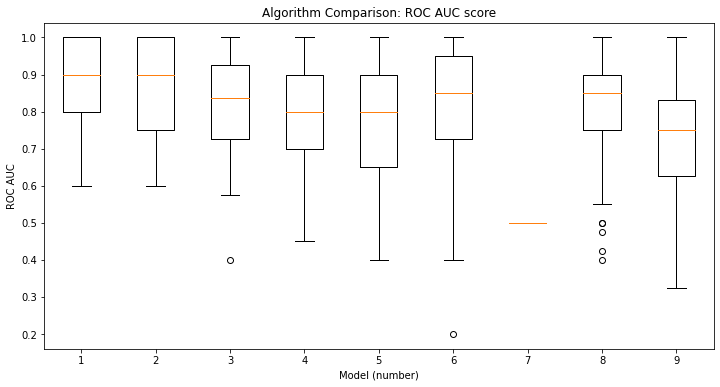

In [36]:
results_roc_auc = [cv_results_lasso_poly_auc, cv_results_lasso_rbf_auc, cv_results_lasso_knn_auc, cv_results_anova_poly_auc, 
           cv_results_anova_rbf_auc, cv_results_anova_knn_auc, cv_results_t_rbf_auc, cv_results_t_knn_auc, cv_results_pca_knn_auc]
plt.boxplot(results_roc_auc)
plt.title('Algorithm Comparison: ROC AUC score')
plt.xlabel('Model (number)')
plt.ylabel('ROC AUC')
plt.show()

# Final evaluation with test set


In [37]:
# Conclusion LASSO + SVC polynomial method works best on the train data 
x_test_scaled = robust_scaler.transform(x_test)

x_test_lasso = selector.transform(x_test_scaled)

predict = model_lasso_poly.predict(x_test_lasso)
print(f' ROC AUC on test set = {roc_auc_score(y_test, predict)}')
print(f' Recall on test set = {recall_score(y_test, predict)}')
print(f' Accuracy on test set = {accuracy_score(y_test, predict)}')

 ROC AUC on test set = 0.787878787878788
 Recall on test set = 0.9090909090909091
 Accuracy on test set = 0.782608695652174
